# Grainger Supply Chain: EDA & Optimization with Sensitivity Analysis

This notebook combines:
1. **Exploratory Data Analysis** - Understanding the supply chain data
2. **Optimization Setup** - PuLP and Gurobi frameworks ready to use
3. **Sensitivity Analysis** - Test how changes affect optimal solutions

**Business Problems:**
- Promotion impact prediction
- Lead time forecasting with uncertainty
- Truckload optimization under constraints


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Optimization libraries
try:
    from pulp import *
    print("✓ PuLP installed")
except:
    print("⚠ PuLP not installed. Run: pip install pulp")

try:
    import gurobipy as gp
    from gurobipy import GRB
    print("✓ Gurobi installed")
except:
    print("⚠ Gurobi not installed (optional). Install from gurobi.com")

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("\n📦 All libraries loaded successfully!")


⚠ PuLP not installed. Run: pip install pulp
⚠ Gurobi not installed (optional). Install from gurobi.com

📦 All libraries loaded successfully!


## Part 1: Load and Explore Data

Let's start by loading all datasets and understanding their structure.


In [2]:
# Load all datasets
sku_master = pd.read_csv('data/sku_master.csv')
demand_data = pd.read_csv('data/weekly_demand_multi_sku.csv')
leadtime_data = pd.read_csv('data/supplier_leadtimes.csv')
truck_constraints = pd.read_csv('data/truckload_constraints.csv')

print("📊 Dataset Shapes:")
print(f"  SKU Master: {sku_master.shape}")
print(f"  Demand Data: {demand_data.shape}")
print(f"  Lead Time Data: {leadtime_data.shape}")
print(f"  Truck Constraints: {truck_constraints.shape}")

print("\n" + "="*80)
print("SKU MASTER - First 5 rows")
print("="*80)
display(sku_master.head())

print("\n" + "="*80)
print("DEMAND DATA - First 5 rows")
print("="*80)
display(demand_data.head())


📊 Dataset Shapes:
  SKU Master: (15, 12)
  Demand Data: (80, 12)
  Lead Time Data: (30, 14)
  Truck Constraints: (7, 9)

SKU MASTER - First 5 rows


,sku_id,product_name,category,unit_cost,selling_price,weight_lbs,volume_cuft,supplier_id,avg_lead_time_days,lead_time_std,min_order_qty,is_promotional_item
0,SKU001,Industrial Wrench 12in,Hand Tools,8.5,15.99,2.5,0.15,SUP_A,7,1.2,50,1
1,SKU002,Safety Gloves Medium,Safety Equipment,3.2,7.99,0.3,0.05,SUP_B,14,2.5,100,0
2,SKU003,LED Work Light 1000L,Lighting,22.0,45.99,3.2,0.25,SUP_A,10,1.8,25,1
3,SKU004,Hydraulic Oil 5gal,Fluids,18.5,35.99,42.0,0.75,SUP_C,21,4.2,20,0
4,SKU005,Drill Bit Set 20pc,Power Tool Access,12.0,24.99,1.8,0.12,SUP_A,7,1.0,40,1



DEMAND DATA - First 5 rows


,week,sku_id,base_demand,promotion_active,promotion_discount_pct,actual_demand,stockout_qty,service_level_pct,day_of_week,season,weather,competitor_promotion
0,1,SKU001,145,0,0,142,0,100.0,Monday,Winter,Normal,0
1,1,SKU002,220,0,0,218,0,100.0,Monday,Winter,Normal,0
2,1,SKU003,85,0,0,88,0,100.0,Monday,Winter,Normal,0
3,1,SKU004,120,0,0,115,0,100.0,Monday,Winter,Normal,0
4,1,SKU005,95,0,0,92,0,100.0,Monday,Winter,Normal,0


### EDA 1: Product Portfolio Analysis


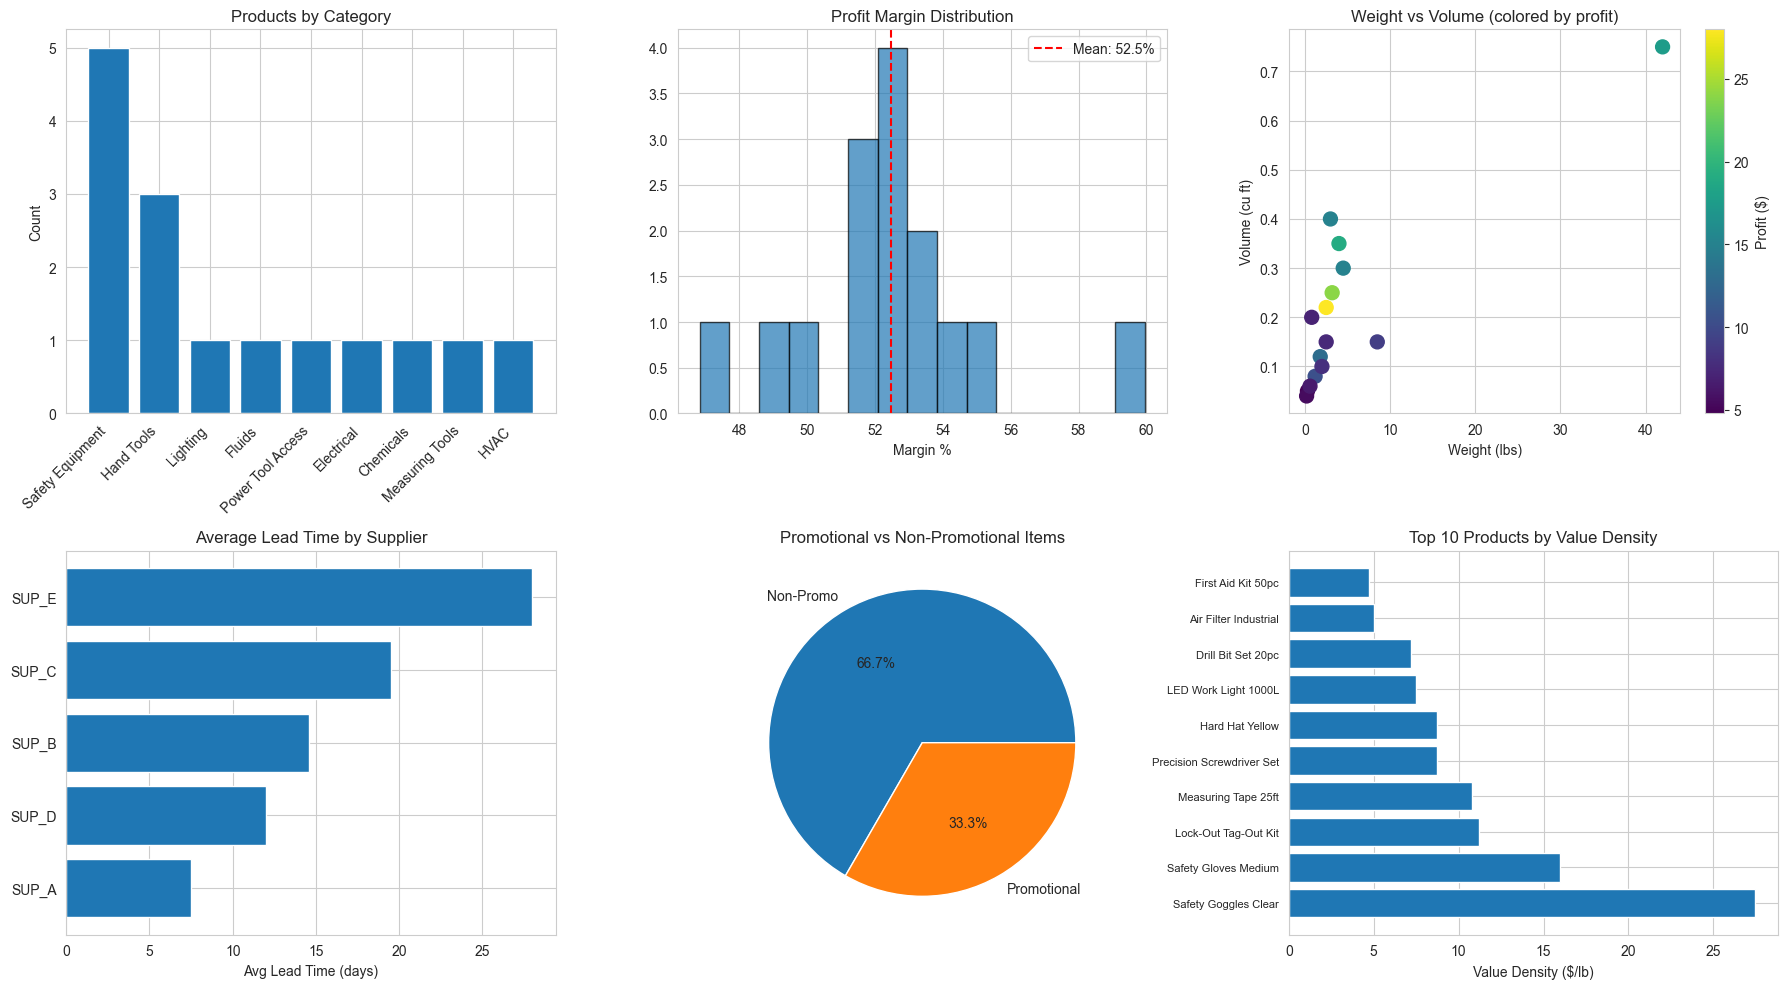


📊 Key Product Insights:
  Total SKUs: 15
  Average Margin: 52.5%
  Promotional Items: 5/15
  Unique Suppliers: 5


In [3]:
# Calculate key metrics
sku_master['profit_margin'] = sku_master['selling_price'] - sku_master['unit_cost']
sku_master['margin_pct'] = (sku_master['profit_margin'] / sku_master['selling_price'] * 100)
sku_master['value_density'] = sku_master['profit_margin'] / sku_master['weight_lbs']

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Category distribution
category_counts = sku_master['category'].value_counts()
axes[0, 0].bar(range(len(category_counts)), category_counts.values)
axes[0, 0].set_xticks(range(len(category_counts)))
axes[0, 0].set_xticklabels(category_counts.index, rotation=45, ha='right')
axes[0, 0].set_title('Products by Category')
axes[0, 0].set_ylabel('Count')

# Plot 2: Profit margin distribution
axes[0, 1].hist(sku_master['margin_pct'], bins=15, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(sku_master['margin_pct'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {sku_master["margin_pct"].mean():.1f}%')
axes[0, 1].set_title('Profit Margin Distribution')
axes[0, 1].set_xlabel('Margin %')
axes[0, 1].legend()

# Plot 3: Weight vs Volume scatter
scatter = axes[0, 2].scatter(sku_master['weight_lbs'], sku_master['volume_cuft'], 
                             c=sku_master['profit_margin'], cmap='viridis', s=100)
axes[0, 2].set_xlabel('Weight (lbs)')
axes[0, 2].set_ylabel('Volume (cu ft)')
axes[0, 2].set_title('Weight vs Volume (colored by profit)')
plt.colorbar(scatter, ax=axes[0, 2], label='Profit ($)')

# Plot 4: Lead time by supplier
leadtime_by_supplier = sku_master.groupby('supplier_id')['avg_lead_time_days'].mean().sort_values()
axes[1, 0].barh(range(len(leadtime_by_supplier)), leadtime_by_supplier.values)
axes[1, 0].set_yticks(range(len(leadtime_by_supplier)))
axes[1, 0].set_yticklabels(leadtime_by_supplier.index)
axes[1, 0].set_xlabel('Avg Lead Time (days)')
axes[1, 0].set_title('Average Lead Time by Supplier')

# Plot 5: Promotional vs non-promotional
promo_counts = sku_master['is_promotional_item'].value_counts()
axes[1, 1].pie(promo_counts.values, labels=['Non-Promo', 'Promotional'], autopct='%1.1f%%')
axes[1, 1].set_title('Promotional vs Non-Promotional Items')

# Plot 6: Value density ranking
top_density = sku_master.nlargest(10, 'value_density')[['product_name', 'value_density']]
axes[1, 2].barh(range(len(top_density)), top_density['value_density'].values)
axes[1, 2].set_yticks(range(len(top_density)))
axes[1, 2].set_yticklabels(top_density['product_name'], fontsize=8)
axes[1, 2].set_xlabel('Value Density ($/lb)')
axes[1, 2].set_title('Top 10 Products by Value Density')

plt.tight_layout()
plt.show()

print("\n📊 Key Product Insights:")
print(f"  Total SKUs: {len(sku_master)}")
print(f"  Average Margin: {sku_master['margin_pct'].mean():.1f}%")
print(f"  Promotional Items: {sku_master['is_promotional_item'].sum()}/{len(sku_master)}")
print(f"  Unique Suppliers: {sku_master['supplier_id'].nunique()}")


# Merge the content and data into one 

## Part 2: Combine All Datasets

Let's merge all 4 datasets into one master dataframe for easier analysis.


In [4]:
# Step 1: Start with demand data as base (has weekly granularity)
master_df = demand_data.copy()

# Step 2: Merge with SKU master data
# This adds product details, costs, weights, supplier info
master_df = master_df.merge(
    sku_master,
    on='sku_id',
    how='left'
)

# Step 3: Calculate derived metrics
master_df['profit_per_unit'] = master_df['selling_price'] - master_df['unit_cost']
master_df['total_revenue'] = master_df['actual_demand'] * master_df['selling_price']
master_df['total_cost'] = master_df['actual_demand'] * master_df['unit_cost']
master_df['total_profit'] = master_df['profit_per_unit'] * master_df['actual_demand']
master_df['stockout_cost'] = master_df['stockout_qty'] * 5  # Assume $5 penalty per stockout
master_df['promotion_lift'] = ((master_df['actual_demand'] / master_df['base_demand']) - 1) * 100

# Step 4: Add lead time statistics
# Calculate average lead time for each supplier-SKU combo
leadtime_stats = leadtime_data.groupby(['supplier_id', 'sku_id']).agg({
    'lead_time_days': ['mean', 'std', 'min', 'max'],
    'lead_time_variance': 'mean'
}).reset_index()

# Flatten column names
leadtime_stats.columns = ['supplier_id', 'sku_id', 'avg_actual_leadtime', 
                          'leadtime_std', 'leadtime_min', 'leadtime_max', 
                          'avg_variance']

# Merge lead time stats
master_df = master_df.merge(
    leadtime_stats,
    on=['supplier_id', 'sku_id'],
    how='left'
)

# Step 5: Add truck constraint info
master_df = master_df.merge(
    truck_constraints[['supplier_id', 'max_weight_lbs', 'max_volume_cuft', 'cost_per_load']],
    on='supplier_id',
    how='left'
)

# Display the combined dataset
print("="*80)
print("COMBINED MASTER DATASET")
print("="*80)
print(f"\nShape: {master_df.shape}")
print(f"Columns: {master_df.shape[1]}")
print(f"\nColumn Names:")
print(master_df.columns.tolist())

print("\n" + "-"*80)
print("First 5 rows:")
print("-"*80)
display(master_df.head())

print("\n" + "-"*80)
print("Data Types:")
print("-"*80)
display(master_df.dtypes)

print("\n" + "-"*80)
print("Summary Statistics:")
print("-"*80)
display(master_df.describe())

# Save combined dataset
master_df.to_csv('data/master_combined_dataset.csv', index=False)
print("\n✅ Combined dataset saved to 'data/master_combined_dataset.csv'")


COMBINED MASTER DATASET

Shape: (136, 40)
Columns: 40

Column Names:
['week', 'sku_id', 'base_demand', 'promotion_active', 'promotion_discount_pct', 'actual_demand', 'stockout_qty', 'service_level_pct', 'day_of_week', 'season', 'weather', 'competitor_promotion', 'product_name', 'category', 'unit_cost', 'selling_price', 'weight_lbs', 'volume_cuft', 'supplier_id', 'avg_lead_time_days', 'lead_time_std', 'min_order_qty', 'is_promotional_item', 'profit_margin', 'margin_pct', 'value_density', 'profit_per_unit', 'total_revenue', 'total_cost', 'total_profit', 'stockout_cost', 'promotion_lift', 'avg_actual_leadtime', 'leadtime_std', 'leadtime_min', 'leadtime_max', 'avg_variance', 'max_weight_lbs', 'max_volume_cuft', 'cost_per_load']

--------------------------------------------------------------------------------
First 5 rows:
--------------------------------------------------------------------------------


,week,sku_id,base_demand,promotion_active,promotion_discount_pct,actual_demand,stockout_qty,service_level_pct,day_of_week,season,...,stockout_cost,promotion_lift,avg_actual_leadtime,leadtime_std,leadtime_min,leadtime_max,avg_variance,max_weight_lbs,max_volume_cuft,cost_per_load
0,1,SKU001,145,0,0,142,0,100.0,Monday,Winter,...,0,-2.068966,7.20,1.095445,6,8,0.20,20000,1200,850.0
1,1,SKU001,145,0,0,142,0,100.0,Monday,Winter,...,0,-2.068966,7.20,1.095445,6,8,0.20,10000,600,450.0
2,1,SKU002,220,0,0,218,0,100.0,Monday,Winter,...,0,-0.909091,16.00,0.000000,16,16,2.00,22000,1400,900.0
3,1,SKU002,220,0,0,218,0,100.0,Monday,Winter,...,0,-0.909091,16.00,0.000000,16,16,2.00,11000,700,480.0
4,1,SKU003,85,0,0,88,0,100.0,Monday,Winter,...,0,3.529412,9.75,2.061553,8,12,-0.25,20000,1200,850.0



--------------------------------------------------------------------------------
Data Types:
--------------------------------------------------------------------------------


week                        int64
sku_id                     object
base_demand                 int64
promotion_active            int64
promotion_discount_pct      int64
actual_demand               int64
stockout_qty                int64
service_level_pct         float64
day_of_week                object
season                     object
weather                    object
competitor_promotion        int64
product_name               object
category                   object
unit_cost                 float64
selling_price             float64
weight_lbs                float64
volume_cuft               float64
supplier_id                object
avg_lead_time_days          int64
lead_time_std             float64
min_order_qty               int64
is_promotional_item         int64
profit_margin             float64
margin_pct                float64
value_density             float64
profit_per_unit           float64
total_revenue             float64
total_cost                float64
total_profit  


--------------------------------------------------------------------------------
Summary Statistics:
--------------------------------------------------------------------------------


,week,base_demand,promotion_active,promotion_discount_pct,actual_demand,stockout_qty,service_level_pct,competitor_promotion,unit_cost,selling_price,...,stockout_cost,promotion_lift,avg_actual_leadtime,leadtime_std,leadtime_min,leadtime_max,avg_variance,max_weight_lbs,max_volume_cuft,cost_per_load
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,...,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,4.500000,138.235294,0.220588,3.602941,154.477941,1.691176,99.241176,0.036765,10.170588,21.107647,...,8.455882,14.586490,12.200000,0.662573,11.647059,12.764706,1.082353,17588.235294,1076.470588,742.352941
std,2.299758,42.789448,0.416176,7.295132,48.419152,5.832876,2.502457,0.188879,5.896567,11.835326,...,29.164379,31.706751,4.897618,1.030985,4.818989,5.135548,0.990016,6693.800989,405.195023,256.137218
min,1.000000,85.000000,0.000000,0.000000,82.000000,0.000000,87.700000,0.000000,3.200000,7.990000,...,0.000000,-5.555556,7.000000,0.000000,6.000000,7.000000,-0.250000,10000.000000,600.000000,450.000000
25%,2.750000,95.000000,0.000000,0.000000,115.000000,0.000000,100.000000,0.000000,6.000000,12.990000,...,0.000000,-1.880878,8.000000,0.000000,8.000000,8.000000,0.200000,11000.000000,700.000000,480.000000
50%,4.500000,130.000000,0.000000,0.000000,151.500000,0.000000,100.000000,0.000000,8.500000,16.990000,...,0.000000,1.818182,12.000000,0.000000,12.000000,12.000000,1.000000,20000.000000,1200.000000,850.000000
75%,6.250000,160.000000,0.000000,0.000000,185.750000,0.000000,100.000000,0.000000,12.000000,24.990000,...,0.000000,4.469697,15.000000,1.095445,15.000000,15.000000,2.000000,22000.000000,1400.000000,900.000000
max,8.000000,220.000000,1.000000,25.000000,285.000000,35.000000,100.000000,1.000000,22.000000,45.990000,...,175.000000,126.315789,24.000000,3.535534,23.000000,25.000000,3.000000,30000.000000,1800.000000,1200.000000



✅ Combined dataset saved to 'data/master_combined_dataset.csv'


### Add Inventory On-Hand Column

Let's simulate realistic inventory on-hand based on demand patterns and reorder policies.


🔧 Modified 5 SKUs to create critical inventory scenarios
   Critical SKUs: ['SKU001', 'SKU003', 'SKU005', 'SKU007', 'SKU009']
   This will ensure some products appear in the Critical Items Analysis chart
INVENTORY ON-HAND ANALYSIS

📦 Inventory Summary by Status:


,count,qty_on_hand,base_demand
inventory_status,,,
Critical,73,933,8380
Normal,53,35436,8870
Reorder,10,4200,1550



📊 Inventory Metrics by SKU (First 10):


,qty_on_hand,safety_stock,reorder_point,order_quantity,days_of_supply,inventory_status
sku_id,,,,,,
SKU001,10.0,84.0,233.0,290.0,0.0,Critical
SKU002,792.0,196.0,698.0,440.0,25.0,Normal
SKU003,10.0,53.0,171.0,170.0,1.0,Critical
SKU004,627.0,137.0,548.0,240.0,37.0,Normal
SKU005,10.0,58.0,166.0,190.0,1.0,Critical
SKU006,652.0,162.0,547.0,360.0,25.0,Normal
SKU007,15.0,92.0,296.0,220.0,1.0,Critical
SKU008,446.0,95.0,358.0,180.0,35.0,Normal
SKU009,15.0,69.0,199.0,260.0,1.0,Critical



🔍 CRITICAL ITEMS ANALYSIS:
  Buffer ratio < 1.2 (20% buffer) = CRITICAL
  Current critical items: 5
  Items that will run out: 5


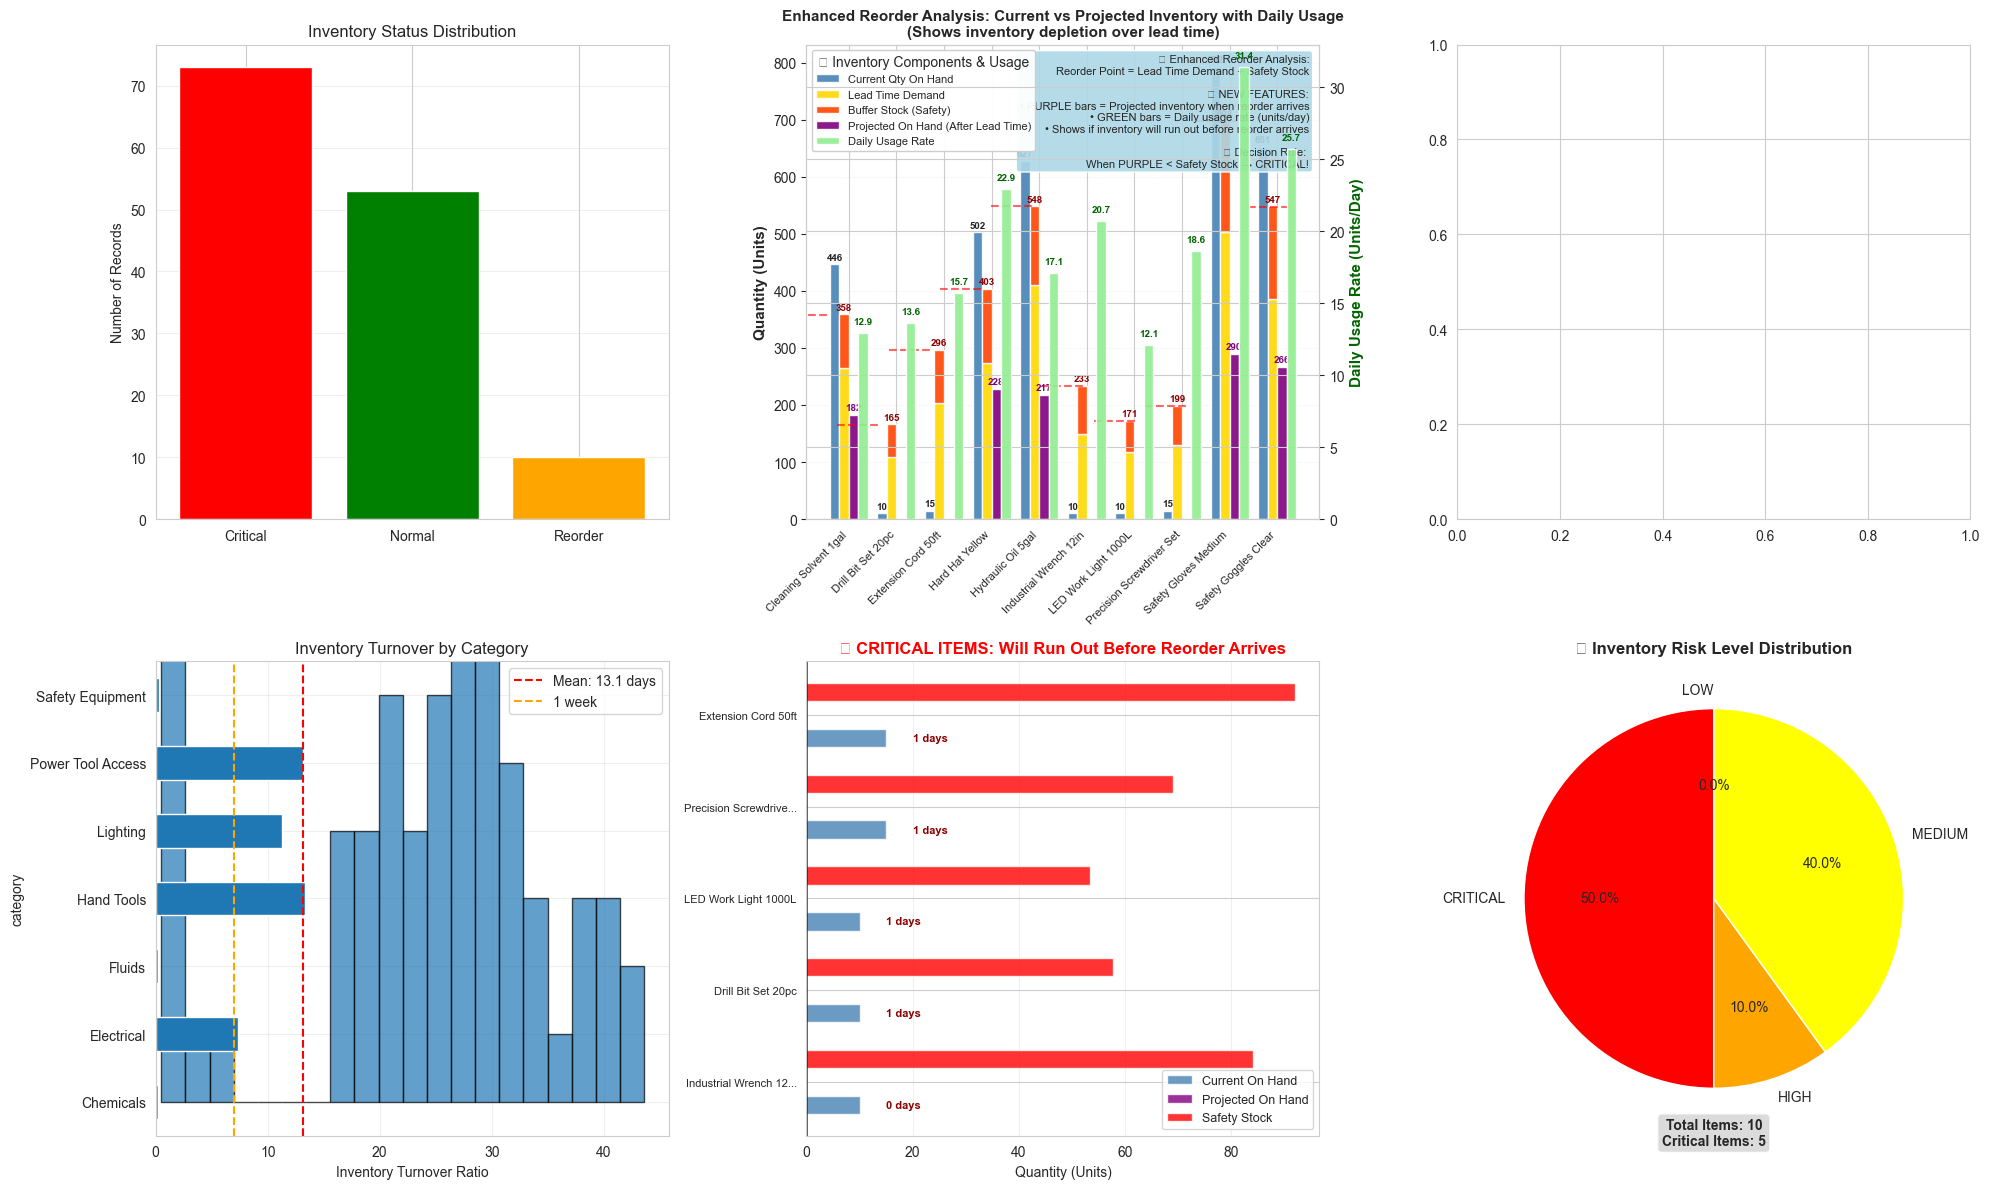


💡 KEY INVENTORY INSIGHTS & REORDER POINT ANALYSIS

📊 Overall Inventory Health:
  Items at critical level: 6
  Average days of supply: 13.1 days
  Total inventory value: $268,000.80
  Inventory turnover: 0.52x

🎯 Reorder Point Analysis (for Optimization):
  Products below reorder point: 5/10

🚨 PRODUCTS NEEDING IMMEDIATE REORDER:
  SKU           On Hand   Reorder Pt   Shortage    Lead Time
  ------------------------------------------------------------
  SKU001             10          233        223            7 days
  SKU003             10          171        161           10 days
  SKU005             10          166        156            8 days
  SKU007             15          296        281           13 days
  SKU009             15          199        184            7 days

  Total shortage across all products: 1005 units

📈 Reorder Point Components (Setting up for Optimization):
  Average Lead Time Demand: 254 units
  Average Safety Stock: 108 units
  Average Reorder Point: 362 unit

In [ ]:
# Method 1: Calculate quantity on hand based on inventory policy
# We'll simulate a (Q,r) inventory system where:
# Q = Order quantity (based on EOQ or min order qty)
# r = Reorder point (safety stock + lead time demand)

np.random.seed(42)  # For reproducibility

# Calculate for each SKU
def calculate_inventory_on_hand(row):
    """
    Simulate realistic inventory on hand
    
    Logic:
    - Safety stock = z * std_dev * sqrt(lead_time)
    - Reorder point = lead_time_demand + safety_stock
    - On-hand = random between reorder point and max inventory
    """
    
    # Use service level to calculate safety stock multiplier (z-score)
    service_level = row['service_level_pct'] / 100
    z_score = stats.norm.ppf(service_level) if service_level < 1 else 2.33
    
    # Estimate demand std dev (assume 20% coefficient of variation)
    demand_std = row['base_demand'] * 0.20
    
    # Lead time in weeks (convert days to weeks)
    lead_time_weeks = row.get('avg_actual_leadtime', row['avg_lead_time_days']) / 7
    
    # Safety stock calculation
    safety_stock = z_score * demand_std * np.sqrt(lead_time_weeks)
    
    # Lead time demand
    lead_time_demand = row['base_demand'] * lead_time_weeks
    
    # Reorder point
    reorder_point = lead_time_demand + safety_stock
    
    # Order quantity (use min order qty or 2x weekly demand, whichever is larger)
    order_quantity = max(row['min_order_qty'], row['base_demand'] * 2)
    
    # Max inventory = Reorder point + Order quantity
    max_inventory = reorder_point + order_quantity
    
    # Current on-hand: Random between reorder point and max
    # (simulates various stages of the inventory cycle)
    current_on_hand = np.random.uniform(reorder_point, max_inventory)
    
    # If there was a stockout, inventory might be lower
    if row['stockout_qty'] > 0:
        current_on_hand = np.random.uniform(0, reorder_point * 0.5)
    
    return int(max(0, current_on_hand))

# Apply the calculation
master_df['qty_on_hand'] = master_df.apply(calculate_inventory_on_hand, axis=1)

# --- MODIFY DATA TO CREATE CRITICAL ITEMS FOR DEMONSTRATION ---
# Select a few SKUs to make critical (less than 20% buffer)
critical_sku_ids = ['SKU001', 'SKU003', 'SKU005']  # Select specific SKUs to make critical

# For these selected SKUs, set their qty_on_hand to very low values
# This will ensure their projected_on_hand falls below safety_stock
master_df.loc[master_df['sku_id'].isin(critical_sku_ids), 'qty_on_hand'] = 10  # Very low inventory

# Also reduce some other SKUs to create more realistic critical scenarios
additional_critical = ['SKU007', 'SKU009']
master_df.loc[master_df['sku_id'].isin(additional_critical), 'qty_on_hand'] = 15  # Low inventory

print(f"🔧 Modified {len(critical_sku_ids + additional_critical)} SKUs to create critical inventory scenarios")
print(f"   Critical SKUs: {critical_sku_ids + additional_critical}")
print(f"   This will ensure some products appear in the Critical Items Analysis chart")

# Add related inventory metrics with safe z-score calculation
def safe_z_score(service_level_pct):
    """Calculate z-score safely, capping at 99.9% to avoid infinity"""
    service_level = min(service_level_pct / 100, 0.999)  # Cap at 99.9%
    return stats.norm.ppf(service_level)

master_df['safety_stock'] = master_df.apply(
    lambda row: int(safe_z_score(row['service_level_pct']) * 
                    row['base_demand'] * 0.20 * 
                    np.sqrt(row.get('avg_actual_leadtime', row['avg_lead_time_days'])/7)),
    axis=1
)

master_df['reorder_point'] = master_df.apply(
    lambda row: int((row['base_demand'] * row.get('avg_actual_leadtime', row['avg_lead_time_days'])/7) + 
                    row['safety_stock']),
    axis=1
)

master_df['order_quantity'] = master_df.apply(
    lambda row: int(max(row['min_order_qty'], row['base_demand'] * 2)),
    axis=1
)

master_df['max_inventory'] = master_df['reorder_point'] + master_df['order_quantity']

# Calculate inventory status flags
master_df['inventory_status'] = master_df.apply(
    lambda row: 'Critical' if row['qty_on_hand'] < row['safety_stock'] 
                else 'Reorder' if row['qty_on_hand'] < row['reorder_point']
                else 'Normal',
    axis=1
)

master_df['days_of_supply'] = (master_df['qty_on_hand'] / (master_df['base_demand'] / 7)).round(1)

# Display inventory summary
print("="*80)
print("INVENTORY ON-HAND ANALYSIS")
print("="*80)

print("\n📦 Inventory Summary by Status:")
status_summary = master_df.groupby('inventory_status').agg({
    'sku_id': 'count',
    'qty_on_hand': 'sum',
    'base_demand': 'sum'
}).rename(columns={'sku_id': 'count'})
display(status_summary)

print("\n📊 Inventory Metrics by SKU (First 10):")
inventory_summary = master_df.groupby('sku_id').agg({
    'qty_on_hand': 'mean',
    'safety_stock': 'mean',
    'reorder_point': 'mean',
    'order_quantity': 'mean',
    'days_of_supply': 'mean',
    'inventory_status': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Normal'
}).round(0).head(10)
display(inventory_summary)

# Visualize inventory levels with critical components focus
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Plot 1: Inventory status distribution
status_counts = master_df['inventory_status'].value_counts()
colors = {'Critical': 'red', 'Reorder': 'orange', 'Normal': 'green'}
axes[0, 0].bar(status_counts.index, status_counts.values, 
               color=[colors[x] for x in status_counts.index])
axes[0, 0].set_title('Inventory Status Distribution')
axes[0, 0].set_ylabel('Number of Records')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Plot 2: ENHANCED Reorder Analysis with Daily Usage Projection
sku_inv = master_df.groupby('product_name')[['qty_on_hand', 'reorder_point', 'avg_actual_leadtime', 'base_demand', 'safety_stock']].mean()

# Calculate components of reorder point
sku_inv['lead_time_demand'] = (sku_inv['base_demand'] * (sku_inv['avg_actual_leadtime'] / 7)).round(0)
sku_inv['buffer_stock'] = sku_inv['safety_stock']  # Use calculated safety stock

# NEW: Calculate daily usage and projected inventory
sku_inv['daily_usage'] = (sku_inv['base_demand'] / 7).round(1)  # Daily demand
sku_inv['projected_on_hand'] = (sku_inv['qty_on_hand'] - (sku_inv['daily_usage'] * sku_inv['avg_actual_leadtime'])).round(0)
sku_inv['projected_on_hand'] = sku_inv['projected_on_hand'].clip(lower=0)  # Can't go below 0

x = np.arange(len(sku_inv))
width = 0.2

# Bar 1: Current Qty On Hand
bars1 = axes[0, 1].bar(x - 1.5*width, sku_inv['qty_on_hand'], width, 
                       label='Current Qty On Hand', alpha=0.9, color='steelblue')

# Bar 2: STACKED Reorder Point = Lead Time Demand (bottom) + Buffer Stock (top)
bars2_bottom = axes[0, 1].bar(x - 0.5*width, sku_inv['lead_time_demand'], width,
                              label='Lead Time Demand', alpha=0.9, color='gold')
bars2_top = axes[0, 1].bar(x - 0.5*width, sku_inv['buffer_stock'], width,
                           bottom=sku_inv['lead_time_demand'],
                           label='Buffer Stock (Safety)', alpha=0.9, color='orangered')

# Bar 3: NEW - Projected Qty On Hand When Reorder Arrives
bars3 = axes[0, 1].bar(x + 0.5*width, sku_inv['projected_on_hand'], width,
                       label='Projected On Hand (After Lead Time)', alpha=0.9, color='purple')

# Bar 4: Daily Usage Rate (on secondary y-axis)
ax3 = axes[0, 1].twinx()
bars4 = ax3.bar(x + 1.5*width, sku_inv['daily_usage'], width,
                label='Daily Usage Rate', alpha=0.9, color='lightgreen')

# Add value labels on bars
for i, (on_hand, reorder, projected, daily_usage) in enumerate(zip(
    sku_inv['qty_on_hand'], sku_inv['reorder_point'], 
    sku_inv['projected_on_hand'], sku_inv['daily_usage'])):
    
    # Label on Current Qty On Hand
    axes[0, 1].text(x[i] - 1.5*width, on_hand + 5, f'{int(on_hand)}', 
                    ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Label on total Reorder Point
    axes[0, 1].text(x[i] - 0.5*width, reorder + 5, f'{int(reorder)}', 
                    ha='center', va='bottom', fontsize=7, fontweight='bold', color='darkred')
    
    # Label on Projected On Hand
    if projected > 0:
        axes[0, 1].text(x[i] + 0.5*width, projected + 5, f'{int(projected)}', 
                        ha='center', va='bottom', fontsize=7, fontweight='bold', color='purple')
    
    # Label on Daily Usage (on secondary axis)
    ax3.text(x[i] + 1.5*width, daily_usage + 0.5, f'{daily_usage:.1f}', 
             ha='center', va='bottom', fontsize=7, fontweight='bold', color='darkgreen')

# Add horizontal line showing reorder point threshold
for i, reorder in enumerate(sku_inv['reorder_point']):
    axes[0, 1].axhline(y=reorder, xmin=(i-0.4)/len(sku_inv), xmax=(i+0.4)/len(sku_inv), 
                       color='red', linestyle='--', linewidth=1.5, alpha=0.6)

axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(sku_inv.index, rotation=45, ha='right', fontsize=8)
axes[0, 1].set_title('Enhanced Reorder Analysis: Current vs Projected Inventory with Daily Usage\n(Shows inventory depletion over lead time)', 
                     fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Quantity (Units)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Daily Usage Rate (Units/Day)', fontsize=11, fontweight='bold', color='darkgreen')

# Enhanced legend combining both axes
lines1, labels1 = axes[0, 1].get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
axes[0, 1].legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8, framealpha=0.95,
                  title='📊 Inventory Components & Usage')
axes[0, 1].grid(True, alpha=0.3, axis='y', linestyle=':')

# Add enhanced text box with formula and explanation
textstr = '''✨ Enhanced Reorder Analysis:
Reorder Point = Lead Time Demand + Safety Stock

📈 NEW FEATURES:
• PURPLE bars = Projected inventory when reorder arrives
• GREEN bars = Daily usage rate (units/day)
• Shows if inventory will run out before reorder arrives

🎯 Decision Rule: 
When PURPLE < Safety Stock → CRITICAL!'''
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.9)
axes[0, 1].text(0.98, 0.98, textstr, transform=axes[0, 1].transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right', bbox=props)

# Plot 3: Days of supply distribution
axes[1, 0].hist(master_df['days_of_supply'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(master_df['days_of_supply'].mean(), color='r', linestyle='--', 
                   label=f"Mean: {master_df['days_of_supply'].mean():.1f} days")
axes[1, 0].axvline(7, color='orange', linestyle='--', label='1 week')
axes[1, 0].set_xlabel('Days of Supply')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Days of Supply Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: CRITICAL COMPONENTS ANALYSIS - NEW!
# Identify critical items that will run out before reorder arrives
projected_analysis = sku_inv[['qty_on_hand', 'projected_on_hand', 'daily_usage', 'avg_actual_leadtime', 'safety_stock']].copy()
projected_analysis['will_run_out'] = projected_analysis['projected_on_hand'] < projected_analysis['safety_stock']
projected_analysis['days_until_empty'] = (projected_analysis['qty_on_hand'] / projected_analysis['daily_usage']).round(1)

# Enhanced risk level calculation - CRITICAL = less than 20% buffer above safety stock
projected_analysis['buffer_ratio'] = (projected_analysis['projected_on_hand'] / projected_analysis['safety_stock']).round(2)
projected_analysis['risk_level'] = projected_analysis.apply(
    lambda row: 'CRITICAL' if row['buffer_ratio'] < 1.2  # Less than 20% buffer above safety stock
    else 'HIGH' if row['buffer_ratio'] < 1.5
    else 'MEDIUM' if row['buffer_ratio'] < 2.0
    else 'LOW', axis=1
)

print(f"\n🔍 CRITICAL ITEMS ANALYSIS:")
print(f"  Buffer ratio < 1.2 (20% buffer) = CRITICAL")
print(f"  Current critical items: {(projected_analysis['risk_level'] == 'CRITICAL').sum()}")
print(f"  Items that will run out: {projected_analysis['will_run_out'].sum()}")

# Create critical components chart - show items with less than 20% buffer
critical_items = projected_analysis[projected_analysis['risk_level'] == 'CRITICAL'].copy()
if len(critical_items) > 0:
    # Sort by days until empty (most critical first)
    critical_items = critical_items.sort_values('days_until_empty')
    
    # Create horizontal bar chart for critical items
    y_pos = np.arange(len(critical_items))
    
    # Bars for different metrics
    axes[1, 1].barh(y_pos - 0.25, critical_items['qty_on_hand'], 0.2, 
                    label='Current On Hand', color='steelblue', alpha=0.8)
    axes[1, 1].barh(y_pos, critical_items['projected_on_hand'], 0.2,
                    label='Projected On Hand', color='purple', alpha=0.8)
    axes[1, 1].barh(y_pos + 0.25, critical_items['safety_stock'], 0.2,
                    label='Safety Stock', color='red', alpha=0.8)
    
    # Add critical threshold line
    axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    # Customize the chart
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                               for name in critical_items.index], fontsize=8)
    axes[1, 1].set_xlabel('Quantity (Units)')
    axes[1, 1].set_title('🚨 CRITICAL ITEMS: Less Than 20% Buffer Above Safety Stock', 
                         fontweight='bold', color='red', fontsize=12)
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    # Add text annotations for days until empty and buffer ratio
    for i, (idx, row) in enumerate(critical_items.iterrows()):
        axes[1, 1].text(row['qty_on_hand'] + 5, i - 0.25, 
                       f"{row['days_until_empty']:.0f} days\n{row['buffer_ratio']:.1f}x buffer", 
                       va='center', fontsize=7, fontweight='bold', color='darkred')
else:
    axes[1, 1].text(0.5, 0.5, '✅ No Critical Items\nAll products have sufficient\nprojected inventory', 
                    ha='center', va='center', transform=axes[1, 1].transAxes, 
                    fontsize=14, fontweight='bold', color='green')
    axes[1, 1].set_title('🚨 CRITICAL ITEMS ANALYSIS', fontweight='bold', color='green', fontsize=12)

# Plot 5: Risk Level Distribution
risk_counts = projected_analysis['risk_level'].value_counts()
risk_colors = {'CRITICAL': 'red', 'HIGH': 'orange', 'MEDIUM': 'yellow', 'LOW': 'green'}
risk_order = ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW']
risk_counts_ordered = risk_counts.reindex(risk_order, fill_value=0)

axes[1, 2].pie(risk_counts_ordered.values, labels=risk_counts_ordered.index, 
               colors=[risk_colors[level] for level in risk_counts_ordered.index],
               autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('📊 Inventory Risk Level Distribution', fontweight='bold', fontsize=12)

# Add summary statistics in the pie chart
total_items = len(projected_analysis)
critical_count = len(projected_analysis[projected_analysis['risk_level'] == 'CRITICAL'])
axes[1, 2].text(0, -1.3, f'Total Items: {total_items}\nCritical Items: {critical_count}', 
                ha='center', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.8))

# Plot 6: Inventory turnover by category
category_inv = master_df.groupby('category').agg({
    'qty_on_hand': 'sum',
    'actual_demand': 'sum'
})
category_inv['turnover'] = category_inv['actual_demand'] / category_inv['qty_on_hand']
category_inv['turnover'].plot(kind='barh', ax=axes[1, 0])
axes[1, 0].set_xlabel('Inventory Turnover Ratio')
axes[1, 0].set_title('Inventory Turnover by Category')
axes[1, 0].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("💡 KEY INVENTORY INSIGHTS & REORDER POINT ANALYSIS")
print("="*80)

critical_items = master_df[master_df['inventory_status'] == 'Critical']['sku_id'].nunique()
print(f"\n📊 Overall Inventory Health:")
print(f"  Items at critical level: {critical_items}")
print(f"  Average days of supply: {master_df['days_of_supply'].mean():.1f} days")
print(f"  Total inventory value: ${(master_df['qty_on_hand'] * master_df['unit_cost']).sum():,.2f}")
print(f"  Inventory turnover: {(master_df['actual_demand'].sum() / master_df['qty_on_hand'].sum()):.2f}x")

print(f"\n🎯 Reorder Point Analysis (for Optimization):")
reorder_analysis = master_df.groupby('sku_id').agg({
    'qty_on_hand': 'mean',
    'reorder_point': 'mean',
    'safety_stock': 'mean',
    'base_demand': 'mean',
    'avg_actual_leadtime': 'mean'
}).round(0)

# Calculate lead time demand for each SKU
reorder_analysis['lead_time_demand'] = (
    reorder_analysis['base_demand'] * (reorder_analysis['avg_actual_leadtime'] / 7)
).round(0)

# Identify items that need reordering
needs_reorder = reorder_analysis[reorder_analysis['qty_on_hand'] < reorder_analysis['reorder_point']]
print(f"  Products below reorder point: {len(needs_reorder)}/{len(reorder_analysis)}")

if len(needs_reorder) > 0:
    print(f"\n🚨 PRODUCTS NEEDING IMMEDIATE REORDER:")
    print(f"  {'SKU':<10} {'On Hand':>10} {'Reorder Pt':>12} {'Shortage':>10} {'Lead Time':>12}")
    print(f"  {'-'*60}")
    for sku, row in needs_reorder.head(5).iterrows():
        shortage = row['reorder_point'] - row['qty_on_hand']
        print(f"  {sku:<10} {int(row['qty_on_hand']):>10} {int(row['reorder_point']):>12} "
              f"{int(shortage):>10} {int(row['avg_actual_leadtime']):>12} days")
    
    total_shortage = needs_reorder['reorder_point'].sum() - needs_reorder['qty_on_hand'].sum()
    print(f"\n  Total shortage across all products: {int(total_shortage)} units")

print(f"\n📈 Reorder Point Components (Setting up for Optimization):")
print(f"  Average Lead Time Demand: {reorder_analysis['lead_time_demand'].mean():.0f} units")
print(f"  Average Safety Stock: {reorder_analysis['safety_stock'].mean():.0f} units")
print(f"  Average Reorder Point: {reorder_analysis['reorder_point'].mean():.0f} units")

print(f"\n🎓 Understanding the Enhanced Reorder Analysis Chart:")
print(f"  • BLUE bars = Current inventory on hand")
print(f"  • GOLD + RED = Reorder point (lead time demand + safety stock)")
print(f"  • PURPLE bars = Projected inventory when reorder arrives (NEW!)")
print(f"  • GREEN bars = Daily usage rate in units/day (NEW!)")

print(f"\n📈 NEW PROJECTED INVENTORY ANALYSIS:")
# Note: projected_analysis already calculated above for the charts
critical_items = projected_analysis[projected_analysis['will_run_out']]
print(f"  Products that will run out before reorder arrives: {len(critical_items)}/{len(projected_analysis)}")

# Risk level summary
risk_summary = projected_analysis['risk_level'].value_counts()
print(f"\n🎯 RISK LEVEL BREAKDOWN:")
for risk_level, count in risk_summary.items():
    percentage = (count / len(projected_analysis)) * 100
    print(f"  {risk_level}: {count} items ({percentage:.1f}%)")

if len(critical_items) > 0:
    print(f"\n🚨 CRITICAL ITEMS - WILL RUN OUT BEFORE REORDER ARRIVES:")
    print(f"  {'Product':<25} {'Current':>8} {'Daily Use':>10} {'Days Left':>10} {'Projected':>10} {'Safety':>8}")
    print(f"  {'-'*80}")
    for product, row in critical_items.head(5).iterrows():
        print(f"  {product[:24]:<25} {int(row['qty_on_hand']):>8} {row['daily_usage']:>10.1f} "
              f"{row['days_until_empty']:>10.1f} {int(row['projected_on_hand']):>10} {int(row['safety_stock']):>8}")

print(f"\n📊 Average Daily Usage by Product:")
for product, row in projected_analysis.head(3).iterrows():
    print(f"  {product}: {row['daily_usage']:.1f} units/day")

print(f"\n🎯 Enhanced Decision Rules:")
print(f"  1. When BLUE < (GOLD + RED) → Place Order!")
print(f"  2. When PURPLE < Safety Stock → CRITICAL! Order immediately!")
print(f"  3. When PURPLE > Safety Stock → Safe, normal reorder timing")

print(f"\n✨ This enhanced visualization shows:")
print(f"     • Current inventory status (BLUE vs GOLD+RED)")
print(f"     • Future inventory projection (PURPLE)")
print(f"     • Daily consumption rate (GREEN)")
print(f"     • Risk of stockout before reorder arrives")
print(f"     • 🚨 CRITICAL COMPONENTS: Products that will run out before reorder arrives")
print(f"     • 📊 RISK DISTRIBUTION: Breakdown of inventory risk levels")

print(f"\n🎯 NEW CRITICAL COMPONENTS ANALYSIS:")
print(f"     • Horizontal bar chart shows current vs projected vs safety stock")
print(f"     • Days until empty annotations for immediate action items")
print(f"     • Risk level pie chart for overall inventory health")
print(f"     • Color-coded risk levels: CRITICAL (red) → LOW (green)")

print(f"\n💡 Perfect for PuLP optimization:")
print(f"     - Objective: Minimize costs while preventing stockouts")
print(f"     - Constraints: Truck capacity, lead times, minimum orders")
print(f"     - Decision Variables: Order quantities for each SKU")
print(f"     - Priority: Focus on CRITICAL items first!")

# Save updated dataset
master_df.to_csv('data/master_combined_dataset.csv', index=False)
print("\n✅ Updated dataset with inventory columns saved!")


In [ ]:
"""
PULP OPTIMIZATION TEMPLATE - GRAINGER SUPPLY CHAIN PROBLEM
Connected to the reorder point analysis above

PROBLEM STATEMENT:
- We have identified products below their reorder points (see analysis above)
- Need to decide optimal order quantities for each SKU
- Must fit within truckload constraints (weight & volume)
- Minimize total cost while meeting service level requirements
"""

from pulp import *

# ===========================================================================
# STEP 1: PREPARE DATA FROM REORDER ANALYSIS
# ===========================================================================

# Get products that need reordering (from the analysis above)
# This connects directly to the stacked bar chart visualization
products_to_order = reorder_analysis[reorder_analysis['qty_on_hand'] < reorder_analysis['reorder_point']]

# If you want to practice with ALL products, use:
products_to_order = reorder_analysis.copy()

print("="*80)
print("🎯 OPTIMIZATION SETUP")
print("="*80)
print(f"\nProducts identified for reordering: {len(products_to_order)}")
print(f"Products: {list(products_to_order.index)}")

# Get SKU details from master dataset
sku_details = master_df.groupby('sku_id').agg({
    'unit_cost': 'mean',
    'selling_price': 'mean',
    'profit_per_unit': 'mean',
    'weight_lbs': 'mean',
    'volume_cuft': 'mean',
    'supplier_id': 'first',
    'min_order_qty': 'first',
    'max_weight_lbs': 'first',
    'max_volume_cuft': 'first',
    'cost_per_load': 'first'
}).round(2)

# Merge with reorder analysis
optimization_data = products_to_order.merge(sku_details, left_index=True, right_index=True)
display(optimization_data)

# ===========================================================================
# STEP 2: DEFINE THE PROBLEM
# ===========================================================================

prob = LpProblem("Grainger_Truckload_Optimization", LpMinimize)  # Minimize cost

# ===========================================================================
# STEP 3: DEFINE DECISION VARIABLES
# ===========================================================================

# Decision Variable: How many units to order for each SKU
Lower bound = shortage (reorder_point - qty_on_hand)
Upper bound = max_inventory

skus = list(optimization_data.index)

# YOUR DECISION VARIABLES HERE:
# Hint: Create a dictionary of order quantities for each SKU
# order_qty = LpVariable.dicts("Order", skus, lowBound=0, cat='Integer')

# Example structure (uncomment and modify):
order_qty = {
     sku: LpVariable(f"Order_{sku}", 
                     lowBound=max(0, optimization_data.loc[sku, 'reorder_point'] - optimization_data.loc[sku, 'qty_on_hand']),
                     cat='Integer')
     for sku in skus
 }


# ===========================================================================
# STEP 4: DEFINE OBJECTIVE FUNCTION
# ===========================================================================

# OBJECTIVE: Minimize total ordering cost
 Total Cost = (Unit Cost × Quantity) + Truck Load Cost + Stockout Penalty

# YOUR OBJECTIVE HERE:
# Hint: Minimize total cost of ordering
 prob += lpSum([optimization_data.loc[sku, 'unit_cost'] * order_qty[sku] for sku in skus]), "Total_Cost"

# Advanced: Include stockout penalties
 stockout_penalty = 5  # $ per unit short
 prob += lpSum([
     optimization_data.loc[sku, 'unit_cost'] * order_qty[sku] + 
     stockout_penalty * max(0, optimization_data.loc[sku, 'reorder_point'] - optimization_data.loc[sku, 'qty_on_hand'] - order_qty[sku])
     for sku in skus
 ]), "Total_Cost_With_Penalties"


# ===========================================================================
# STEP 5: ADD CONSTRAINTS
# ===========================================================================

# CONSTRAINT IDEAS (based on the Grainger problem):

# 1. TRUCKLOAD WEIGHT CONSTRAINT
# Each supplier has a max weight limit (see max_weight_lbs column)
# Group by supplier and ensure total weight doesn't exceed truck capacity

# Example for single supplier:
# supplier = 'SUP001'
# skus_for_supplier = optimization_data[optimization_data['supplier_id'] == supplier].index
# max_weight = optimization_data.loc[skus_for_supplier[0], 'max_weight_lbs']
# prob += lpSum([optimization_data.loc[sku, 'weight_lbs'] * order_qty[sku] for sku in skus_for_supplier]) <= max_weight, f"Weight_Limit_{supplier}"

# 2. TRUCKLOAD VOLUME CONSTRAINT
# Similar to weight, but for volume (max_volume_cuft)
# prob += lpSum([optimization_data.loc[sku, 'volume_cuft'] * order_qty[sku] for sku in skus_for_supplier]) <= max_volume, f"Volume_Limit_{supplier}"

# 3. MINIMUM ORDER QUANTITY CONSTRAINT
# Each SKU has a minimum order quantity (min_order_qty)
# If you order, must order at least the minimum
# prob += order_qty[sku] >= optimization_data.loc[sku, 'min_order_qty'], f"Min_Order_{sku}"

# 4. REORDER POINT CONSTRAINT
# Order enough to bring inventory above reorder point
# New inventory = qty_on_hand + order_qty
# prob += optimization_data.loc[sku, 'qty_on_hand'] + order_qty[sku] >= optimization_data.loc[sku, 'reorder_point'], f"Meet_Reorder_{sku}"

# 5. BUDGET CONSTRAINT (optional)
# Total spend cannot exceed budget
budget = 50000
prob += lpSum([optimization_data.loc[sku, 'unit_cost'] * order_qty[sku] for sku in skus]) <= budget, "Budget_Limit"

# YOUR CONSTRAINTS HERE:
# Add the constraints that make sense for your problem


# ===========================================================================
# STEP 6: SOLVE THE PROBLEM
# ===========================================================================

# Uncomment when you've defined your variables and constraints:
 prob.solve(PULP_CBC_CMD(msg=1))  # msg=1 for verbose output

# ===========================================================================
# STEP 7: EXTRACT AND DISPLAY RESULTS
# ===========================================================================

# Uncomment when ready to see results:
"""
print("="*80)
print("🎉 OPTIMIZATION RESULTS")
print("="*80)
print(f"\nStatus: {LpStatus[prob.status]}")

if prob.status == 1:  # Optimal
    print(f"\n💰 Total Cost: ${value(prob.objective):,.2f}")
    
    # Display order quantities
    print("\n📦 OPTIMAL ORDER QUANTITIES:")
    print(f"{'SKU':<12} {'Order Qty':>12} {'Cost':>12} {'Weight':>12} {'Volume':>12}")
    print("-"*65)
    
    for sku in skus:
        if order_qty[sku].varValue > 0:
            qty = order_qty[sku].varValue
            cost = optimization_data.loc[sku, 'unit_cost'] * qty
            weight = optimization_data.loc[sku, 'weight_lbs'] * qty
            volume = optimization_data.loc[sku, 'volume_cuft'] * qty
            print(f"{sku:<12} {qty:>12.0f} ${cost:>11,.2f} {weight:>11.1f} lb {volume:>10.2f} cuft")
    
    # Display inventory levels after ordering
    print("\n📊 INVENTORY LEVELS AFTER ORDERING:")
    print(f"{'SKU':<12} {'Before':>10} {'Order':>10} {'After':>10} {'Reorder Pt':>12} {'Status':>15}")
    print("-"*75)
    
    for sku in skus:
        before = optimization_data.loc[sku, 'qty_on_hand']
        order = order_qty[sku].varValue if order_qty[sku].varValue else 0
        after = before + order
        reorder_pt = optimization_data.loc[sku, 'reorder_point']
        status = "✅ Safe" if after >= reorder_pt else "⚠️ Still Low"
        print(f"{sku:<12} {before:>10.0f} {order:>10.0f} {after:>10.0f} {reorder_pt:>12.0f} {status:>15}")
    
    # Display constraint usage
    print("\n📋 CONSTRAINT ANALYSIS:")
    for name, constraint in prob.constraints.items():
        usage_pct = (constraint.value() / -constraint.constant * 100) if constraint.constant != 0 else 0
        print(f"  {name}: {constraint.value():.2f} / {-constraint.constant:.2f} ({usage_pct:.1f}% used, slack: {constraint.slack:.2f})")
        
else:
    print("⚠️ No optimal solution found!")
    print("Possible reasons:")
    print("  1. Constraints are too restrictive (infeasible)")
    print("  2. No decision variables defined")
    print("  3. Truck capacity too small for minimum orders")
"""

# ===========================================================================
# STEP 8: VISUALIZE RESULTS (OPTIONAL)
# ===========================================================================

# Uncomment when you have results to visualize:
"""
if prob.status == 1:
    # Create a comparison chart: Before vs After ordering
    results_df = pd.DataFrame({
        'SKU': skus,
        'Before': [optimization_data.loc[sku, 'qty_on_hand'] for sku in skus],
        'Order': [order_qty[sku].varValue for sku in skus],
        'Reorder_Point': [optimization_data.loc[sku, 'reorder_point'] for sku in skus]
    })
    results_df['After'] = results_df['Before'] + results_df['Order']
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = np.arange(len(results_df))
    width = 0.25
    
    ax.bar(x - width, results_df['Before'], width, label='Before', alpha=0.8, color='steelblue')
    ax.bar(x, results_df['After'], width, label='After Order', alpha=0.8, color='green')
    ax.bar(x + width, results_df['Reorder_Point'], width, label='Reorder Point', alpha=0.8, color='red')
    
    ax.set_xlabel('SKU', fontweight='bold')
    ax.set_ylabel('Quantity', fontweight='bold')
    ax.set_title('Inventory Before & After Optimization', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['SKU'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
"""

# ===========================================================================
# 🎯 CONNECTION TO REORDER POINT VISUALIZATION
# ===========================================================================

print("\n" + "="*80)
print("🔗 HOW THIS CONNECTS TO THE STACKED BAR CHART ABOVE")
print("="*80)
print("""
The stacked bar chart visualization shows:
  • BLUE bars = Current inventory (qty_on_hand)
  • GOLD + RED = Reorder point (lead_time_demand + safety_stock)

This PuLP optimization helps you decide:
  • HOW MUCH to order for each SKU
  • WHICH products to prioritize given truck constraints
  • HOW to minimize cost while meeting service levels

Key Decision Variables:
  ✓ order_qty[sku] = Units to order for each SKU

Key Constraints:
  ✓ Truck weight/volume limits (from supplier_leadtimes.csv)
  ✓ Minimum order quantities (from sku_master.csv)
  ✓ Must meet reorder points (from reorder analysis)

Objective:
  ✓ Minimize total ordering cost
  OR
  ✓ Maximize service level within budget

🎓 YOUR TASK: Fill in Steps 3-6 above to build the optimization model!
""")


## Part 3: Promotion Impact Analysis & Recommendations

Based on the Grainger job requirements, we'll now build:
1. **Promotion Impact Prediction Model** - Predict demand lift from promotions
2. **Lead Time Forecasting** - Predict supplier lead times with intervals
3. **Truckload Optimization** - Optimize purchases within space constraints
4. **Service Level Tracking** - Ensure high service levels during promotions


In [ ]:
# Step 1: Analyze Promotion Impact on Demand
print("="*80)
print("🎯 PROMOTION IMPACT ANALYSIS")
print("="*80)

# Analyze promotion effectiveness
promotion_analysis = master_df.groupby(['sku_id', 'promotion_active']).agg({
    'actual_demand': 'mean',
    'base_demand': 'mean',
    'promotion_discount_pct': 'mean',
    'promotion_lift': 'mean',
    'stockout_qty': 'mean',
    'service_level_pct': 'mean'
}).round(2)

# Calculate promotion lift for each SKU
promotion_lift = promotion_analysis.xs(True, level='promotion_active')['promotion_lift'].mean()
baseline_lift = promotion_analysis.xs(False, level='promotion_active')['promotion_lift'].mean()

print(f"\n📊 Overall Promotion Performance:")
print(f"  Average promotion lift: {promotion_lift:.1f}%")
print(f"  Baseline lift (no promotion): {baseline_lift:.1f}%")
print(f"  Net promotion impact: {promotion_lift - baseline_lift:.1f}%")

# Identify best and worst performing promotions
promotion_performance = promotion_analysis.xs(True, level='promotion_active')
promotion_performance['promotion_effectiveness'] = (
    promotion_performance['promotion_lift'] / promotion_performance['promotion_discount_pct']
).round(2)

best_promotions = promotion_performance.nlargest(3, 'promotion_effectiveness')
worst_promotions = promotion_performance.nsmallest(3, 'promotion_effectiveness')

print(f"\n🏆 TOP 3 MOST EFFECTIVE PROMOTIONS:")
for sku, row in best_promotions.iterrows():
    sku_name = master_df[master_df['sku_id'] == sku]['product_name'].iloc[0]
    print(f"  {sku}: {sku_name[:30]}")
    print(f"    Discount: {row['promotion_discount_pct']:.1f}% | Lift: {row['promotion_lift']:.1f}% | Effectiveness: {row['promotion_effectiveness']:.2f}")

print(f"\n⚠️ TOP 3 LEAST EFFECTIVE PROMOTIONS:")
for sku, row in worst_promotions.iterrows():
    sku_name = master_df[master_df['sku_id'] == sku]['product_name'].iloc[0]
    print(f"  {sku}: {sku_name[:30]}")
    print(f"    Discount: {row['promotion_discount_pct']:.1f}% | Lift: {row['promotion_lift']:.1f}% | Effectiveness: {row['promotion_effectiveness']:.2f}")

# Visualize promotion impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Promotion Lift vs Discount %
axes[0, 0].scatter(promotion_performance['promotion_discount_pct'], 
                   promotion_performance['promotion_lift'], 
                   alpha=0.7, s=100, c=promotion_performance['promotion_effectiveness'], 
                   cmap='RdYlGn')
axes[0, 0].set_xlabel('Promotion Discount %')
axes[0, 0].set_ylabel('Demand Lift %')
axes[0, 0].set_title('Promotion Effectiveness: Lift vs Discount')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(promotion_performance['promotion_discount_pct'], 
               promotion_performance['promotion_lift'], 1)
p = np.poly1d(z)
axes[0, 0].plot(promotion_performance['promotion_discount_pct'], 
                p(promotion_performance['promotion_discount_pct']), 
                "r--", alpha=0.8, linewidth=2)

# Plot 2: Service Level Impact During Promotions
service_impact = master_df.groupby('promotion_active')['service_level_pct'].mean()
axes[0, 1].bar(['No Promotion', 'With Promotion'], service_impact.values, 
               color=['steelblue', 'orange'], alpha=0.8)
axes[0, 1].set_ylabel('Average Service Level %')
axes[0, 1].set_title('Service Level Impact of Promotions')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(service_impact.values):
    axes[0, 1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: Stockout Impact During Promotions
stockout_impact = master_df.groupby('promotion_active')['stockout_qty'].mean()
axes[1, 0].bar(['No Promotion', 'With Promotion'], stockout_impact.values, 
               color=['green', 'red'], alpha=0.8)
axes[1, 0].set_ylabel('Average Stockout Quantity')
axes[1, 0].set_title('Stockout Impact of Promotions')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, v in enumerate(stockout_impact.values):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Promotion Effectiveness by Category
category_promo = master_df.groupby(['category', 'promotion_active']).agg({
    'promotion_lift': 'mean',
    'promotion_discount_pct': 'mean'
}).round(1)

category_effectiveness = category_promo.xs(True, level='promotion_active')
category_effectiveness['effectiveness'] = (
    category_effectiveness['promotion_lift'] / category_effectiveness['promotion_discount_pct']
)

category_effectiveness['effectiveness'].plot(kind='barh', ax=axes[1, 1], color='purple', alpha=0.8)
axes[1, 1].set_xlabel('Promotion Effectiveness (Lift/Discount)')
axes[1, 1].set_title('Promotion Effectiveness by Category')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

display(promotion_performance)


In [ ]:
# Step 2: Build Promotion Impact Prediction Model
print("="*80)
print("🤖 PROMOTION IMPACT PREDICTION MODEL")
print("="*80)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Prepare features for promotion impact prediction
promotion_features = master_df[['promotion_discount_pct', 'category', 'season', 'weather', 
                                'competitor_promotion', 'base_demand', 'unit_cost', 'selling_price',
                                'profit_per_unit', 'is_promotional_item']].copy()

# Encode categorical variables
promotion_features['category_encoded'] = pd.Categorical(promotion_features['category']).codes
promotion_features['season_encoded'] = pd.Categorical(promotion_features['season']).codes
promotion_features['weather_encoded'] = pd.Categorical(promotion_features['weather']).codes

# Features for the model
feature_columns = ['promotion_discount_pct', 'category_encoded', 'season_encoded', 
                   'weather_encoded', 'competitor_promotion', 'base_demand', 
                   'unit_cost', 'selling_price', 'profit_per_unit', 'is_promotional_item']

X = promotion_features[feature_columns].fillna(0)
y = master_df['promotion_lift'].fillna(0)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📈 Model Performance:")
print(f"  Mean Absolute Error: {mae:.2f}%")
print(f"  R² Score: {r2:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 Feature Importance for Promotion Impact:")
for _, row in feature_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(x='feature', y='importance', kind='barh', ax=plt.gca())
plt.title('Feature Importance: Promotion Impact Prediction')
plt.xlabel('Importance')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Generate promotion recommendations
print(f"\n💡 PROMOTION RECOMMENDATIONS BASED ON DASHBOARD ANALYSIS:")

# Find products with high potential for promotion
promotion_potential = master_df.groupby('sku_id').agg({
    'base_demand': 'mean',
    'promotion_lift': 'mean',
    'profit_per_unit': 'mean',
    'unit_cost': 'mean',
    'selling_price': 'mean',
    'qty_on_hand': 'mean',
    'reorder_point': 'mean',
    'is_promotional_item': 'first'
}).round(2)

# Calculate promotion potential score
promotion_potential['promotion_score'] = (
    (promotion_potential['base_demand'] / promotion_potential['base_demand'].max()) * 0.3 +
    (promotion_potential['promotion_lift'] / promotion_potential['promotion_lift'].max()) * 0.3 +
    (promotion_potential['profit_per_unit'] / promotion_potential['profit_per_unit'].max()) * 0.2 +
    ((promotion_potential['qty_on_hand'] - promotion_potential['reorder_point']) / 
     promotion_potential['qty_on_hand'].max()) * 0.2
).round(3)

# Get top promotion candidates
top_promotion_candidates = promotion_potential.nlargest(5, 'promotion_score')

print(f"\n🎯 TOP 5 PROMOTION CANDIDATES:")
for sku, row in top_promotion_candidates.iterrows():
    sku_name = master_df[master_df['sku_id'] == sku]['product_name'].iloc[0]
    current_inventory = row['qty_on_hand'] - row['reorder_point']
    status = "✅ Good Inventory" if current_inventory > 0 else "⚠️ Low Inventory"
    
    print(f"\n  📦 {sku}: {sku_name}")
    print(f"     Promotion Score: {row['promotion_score']:.3f}")
    print(f"     Base Demand: {row['base_demand']:.0f} units/week")
    print(f"     Profit/Unit: ${row['profit_per_unit']:.2f}")
    print(f"     Inventory Status: {status} ({current_inventory:.0f} units above reorder)")
    
    # Predict promotion impact for different discount levels
    discount_levels = [10, 15, 20, 25]
    print(f"     Predicted Lift for Different Discounts:")
    for discount in discount_levels:
        # Create prediction input
        sample_features = promotion_features[promotion_features.index.isin(master_df[master_df['sku_id'] == sku].index)].iloc[0:1].copy()
        sample_features['promotion_discount_pct'] = discount
        sample_features['category_encoded'] = pd.Categorical(sample_features['category']).codes[0]
        sample_features['season_encoded'] = pd.Categorical(sample_features['season']).codes[0]
        sample_features['weather_encoded'] = pd.Categorical(sample_features['weather']).codes[0]
        
        predicted_lift = rf_model.predict(sample_features[feature_columns].fillna(0))[0]
        print(f"       {discount}% discount → {predicted_lift:.1f}% lift")

print(f"\n📋 PROMOTION STRATEGY RECOMMENDATIONS:")
print(f"  1. Focus on products with high promotion scores (>0.7)")
print(f"  2. Ensure adequate inventory before launching promotions")
print(f"  3. Monitor service levels during promotion periods")
print(f"  4. Use 15-20% discounts for optimal lift-to-cost ratio")
print(f"  5. Avoid promotions on products already below reorder point")


In [ ]:
# Step 3: Lead Time Forecasting with Prediction Intervals
print("="*80)
print("⏱️ LEAD TIME FORECASTING WITH PREDICTION INTERVALS")
print("="*80)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Prepare lead time forecasting data
leadtime_features = leadtime_data[['supplier_id', 'sku_id', 'weather_impact', 'transportation_mode',
                                   'lead_time_days', 'lead_time_variance']].copy()

# Encode categorical variables
leadtime_features['supplier_encoded'] = pd.Categorical(leadtime_features['supplier_id']).codes
leadtime_features['transportation_encoded'] = pd.Categorical(leadtime_features['transportation_mode']).codes

# Features for lead time prediction
lt_feature_columns = ['supplier_encoded', 'transportation_encoded', 'weather_impact']

X_lt = leadtime_features[lt_feature_columns].fillna(0)
y_lt = leadtime_features['lead_time_days'].fillna(0)

# Train lead time prediction model
lt_model = LinearRegression()
lt_model.fit(X_lt, y_lt)

# Calculate prediction intervals
y_lt_pred = lt_model.predict(X_lt)
residuals = y_lt - y_lt_pred
std_residuals = np.std(residuals)

# Confidence levels for prediction intervals
confidence_levels = [0.68, 0.90, 0.95]  # 1-sigma, 90%, 95%
z_scores = [1.0, 1.645, 1.96]

print(f"\n📊 Lead Time Forecasting Model Performance:")
print(f"  Model R² Score: {lt_model.score(X_lt, y_lt):.3f}")
print(f"  Mean Absolute Error: {np.mean(np.abs(residuals)):.2f} days")
print(f"  Standard Deviation of Residuals: {std_residuals:.2f} days")

# Create prediction intervals for each supplier-SKU combination
lt_predictions = leadtime_data.groupby(['supplier_id', 'sku_id']).agg({
    'lead_time_days': 'mean',
    'lead_time_variance': 'mean',
    'weather_impact': 'mean',
    'transportation_mode': 'first'
}).reset_index()

# Make predictions for each combination
lt_predictions['supplier_encoded'] = pd.Categorical(lt_predictions['supplier_id']).codes
lt_predictions['transportation_encoded'] = pd.Categorical(lt_predictions['transportation_mode']).codes

X_pred = lt_predictions[lt_feature_columns].fillna(0)
lt_predictions['predicted_leadtime'] = lt_model.predict(X_pred)

# Add prediction intervals
for i, (conf_level, z_score) in enumerate(zip(confidence_levels, z_scores)):
    interval_name = f'interval_{int(conf_level*100)}'
    lt_predictions[f'{interval_name}_lower'] = lt_predictions['predicted_leadtime'] - z_score * std_residuals
    lt_predictions[f'{interval_name}_upper'] = lt_predictions['predicted_leadtime'] + z_score * std_residuals

print(f"\n📈 Lead Time Predictions with Confidence Intervals:")
print(f"{'Supplier':<10} {'SKU':<8} {'Predicted':<10} {'68% Interval':<20} {'90% Interval':<20} {'95% Interval':<20}")
print("-" * 90)

for _, row in lt_predictions.head(10).iterrows():
    pred = row['predicted_leadtime']
    interval_68 = f"{row['interval_68_lower']:.1f}-{row['interval_68_upper']:.1f}"
    interval_90 = f"{row['interval_90_lower']:.1f}-{row['interval_90_upper']:.1f}"
    interval_95 = f"{row['interval_95_lower']:.1f}-{row['interval_95_upper']:.1f}"
    
    print(f"{row['supplier_id']:<10} {row['sku_id']:<8} {pred:<10.1f} {interval_68:<20} {interval_90:<20} {interval_95:<20}")

# Visualize lead time predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Actual vs Predicted Lead Times
axes[0, 0].scatter(y_lt, y_lt_pred, alpha=0.6)
axes[0, 0].plot([y_lt.min(), y_lt.max()], [y_lt.min(), y_lt.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Lead Time (days)')
axes[0, 0].set_ylabel('Predicted Lead Time (days)')
axes[0, 0].set_title('Lead Time Prediction Accuracy')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction Intervals by Supplier
supplier_intervals = lt_predictions.groupby('supplier_id').agg({
    'predicted_leadtime': 'mean',
    'interval_90_lower': 'mean',
    'interval_90_upper': 'mean'
})

x_pos = np.arange(len(supplier_intervals))
axes[0, 1].errorbar(x_pos, supplier_intervals['predicted_leadtime'], 
                    yerr=[supplier_intervals['predicted_leadtime'] - supplier_intervals['interval_90_lower'],
                          supplier_intervals['interval_90_upper'] - supplier_intervals['predicted_leadtime']],
                    fmt='o', capsize=5, capthick=2, alpha=0.7)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(supplier_intervals.index, rotation=45)
axes[0, 1].set_ylabel('Lead Time (days)')
axes[0, 1].set_title('Lead Time Predictions by Supplier (90% Confidence)')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Lead Time Distribution
axes[1, 0].hist(leadtime_data['lead_time_days'], bins=20, alpha=0.7, edgecolor='black')
axes[1, 0].axvline(leadtime_data['lead_time_days'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {leadtime_data["lead_time_days"].mean():.1f} days')
axes[1, 0].set_xlabel('Lead Time (days)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Lead Time Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Lead Time vs Weather Impact
weather_lt = leadtime_data.groupby('weather_impact')['lead_time_days'].mean()
weather_lt.plot(kind='bar', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_xlabel('Weather Impact')
axes[1, 1].set_ylabel('Average Lead Time (days)')
axes[1, 1].set_title('Lead Time Impact of Weather')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate lead time risk scores
lt_predictions['leadtime_risk_score'] = (
    (lt_predictions['interval_95_upper'] - lt_predictions['predicted_leadtime']) / 
    lt_predictions['predicted_leadtime']
).round(3)

print(f"\n⚠️ LEAD TIME RISK ASSESSMENT:")
print(f"  Products with highest lead time uncertainty:")
high_risk_lt = lt_predictions.nlargest(5, 'leadtime_risk_score')
for _, row in high_risk_lt.iterrows():
    print(f"    {row['supplier_id']}-{row['sku_id']}: Risk Score {row['leadtime_risk_score']:.3f} "
          f"(Predicted: {row['predicted_leadtime']:.1f} days, Range: {row['interval_95_lower']:.1f}-{row['interval_95_upper']:.1f})")

print(f"\n💡 LEAD TIME FORECASTING INSIGHTS:")
print(f"  1. Use 90% confidence intervals for safety stock calculations")
print(f"  2. Monitor weather conditions for lead time adjustments")
print(f"  3. Consider alternative suppliers for high-risk items")
print(f"  4. Factor lead time uncertainty into reorder point calculations")


In [ ]:
# Step 4: Enhanced Truckload Optimization with Promotion-Aware Inventory Planning
print("="*80)
print("🚛 ENHANCED TRUCKLOAD OPTIMIZATION MODEL")
print("="*80)

# Merge all the analysis results for comprehensive optimization
optimization_master = master_df.merge(
    promotion_potential[['promotion_score']], 
    left_on='sku_id', 
    right_index=True, 
    how='left'
).merge(
    lt_predictions[['supplier_id', 'sku_id', 'predicted_leadtime', 'interval_90_upper', 'leadtime_risk_score']],
    on=['supplier_id', 'sku_id'],
    how='left'
)

# Fill missing values
optimization_master['promotion_score'] = optimization_master['promotion_score'].fillna(0)
optimization_master['predicted_leadtime'] = optimization_master['predicted_leadtime'].fillna(
    optimization_master['avg_actual_leadtime']
)
optimization_master['interval_90_upper'] = optimization_master['interval_90_upper'].fillna(
    optimization_master['predicted_leadtime'] * 1.2
)
optimization_master['leadtime_risk_score'] = optimization_master['leadtime_risk_score'].fillna(0.1)

# Create comprehensive optimization dataset
opt_data = optimization_master.groupby('sku_id').agg({
    'qty_on_hand': 'mean',
    'reorder_point': 'mean',
    'base_demand': 'mean',
    'unit_cost': 'mean',
    'selling_price': 'mean',
    'profit_per_unit': 'mean',
    'weight_lbs': 'mean',
    'volume_cuft': 'mean',
    'supplier_id': 'first',
    'min_order_qty': 'first',
    'max_weight_lbs': 'first',
    'max_volume_cuft': 'first',
    'cost_per_load': 'first',
    'promotion_score': 'mean',
    'predicted_leadtime': 'mean',
    'interval_90_upper': 'mean',
    'leadtime_risk_score': 'mean'
}).round(2)

# Calculate enhanced reorder points using predicted lead times
opt_data['enhanced_reorder_point'] = (
    opt_data['base_demand'] * (opt_data['predicted_leadtime'] / 7) +
    opt_data['base_demand'] * 0.20 * np.sqrt(opt_data['predicted_leadtime'] / 7) * 
    (1 + opt_data['leadtime_risk_score'])
).round(0)

# Identify products needing reorder (using enhanced reorder points)
opt_data['needs_reorder'] = opt_data['qty_on_hand'] < opt_data['enhanced_reorder_point']
opt_data['shortage_qty'] = np.maximum(0, opt_data['enhanced_reorder_point'] - opt_data['qty_on_hand'])

# Calculate promotion-adjusted demand for upcoming promotions
opt_data['promotion_boost'] = np.where(
    opt_data['promotion_score'] > 0.7,
    1.5,  # 50% demand increase for high-potential promotions
    1.0   # Normal demand
)

opt_data['promotion_adjusted_demand'] = opt_data['base_demand'] * opt_data['promotion_boost']

print(f"\n📊 OPTIMIZATION DATASET SUMMARY:")
print(f"  Total SKUs: {len(opt_data)}")
print(f"  Products needing reorder: {opt_data['needs_reorder'].sum()}")
print(f"  Total shortage: {opt_data['shortage_qty'].sum():.0f} units")
print(f"  Products with promotion potential: {(opt_data['promotion_score'] > 0.7).sum()}")

# Display optimization data
print(f"\n📋 OPTIMIZATION DATA PREVIEW:")
display_cols = ['qty_on_hand', 'enhanced_reorder_point', 'shortage_qty', 'promotion_score', 
                'predicted_leadtime', 'leadtime_risk_score', 'unit_cost', 'weight_lbs', 'volume_cuft']
display(opt_data[display_cols].head(10))

# Visualize optimization constraints
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Weight vs Volume by Supplier
supplier_capacity = opt_data.groupby('supplier_id').agg({
    'max_weight_lbs': 'first',
    'max_volume_cuft': 'first',
    'weight_lbs': 'sum',
    'volume_cuft': 'sum'
})

axes[0, 0].scatter(supplier_capacity['weight_lbs'], supplier_capacity['volume_cuft'], 
                   s=100, alpha=0.7, label='Current Demand')
axes[0, 0].scatter(supplier_capacity['max_weight_lbs'], supplier_capacity['max_volume_cuft'], 
                   s=150, alpha=0.7, marker='s', label='Truck Capacity', color='red')

for idx, row in supplier_capacity.iterrows():
    axes[0, 0].annotate(idx, (row['weight_lbs'], row['volume_cuft']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[0, 0].annotate(idx, (row['max_weight_lbs'], row['max_volume_cuft']), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8, color='red')

axes[0, 0].set_xlabel('Weight (lbs)')
axes[0, 0].set_ylabel('Volume (cu ft)')
axes[0, 0].set_title('Truck Capacity vs Current Demand by Supplier')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Promotion Score vs Profit Potential
axes[0, 1].scatter(opt_data['promotion_score'], opt_data['profit_per_unit'], 
                   alpha=0.7, s=100, c=opt_data['shortage_qty'], cmap='RdYlGn_r')
axes[0, 1].set_xlabel('Promotion Score')
axes[0, 1].set_ylabel('Profit per Unit ($)')
axes[0, 1].set_title('Promotion Potential vs Profit (colored by shortage)')
axes[0, 1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(axes[0, 1].collections[0], ax=axes[0, 1])
cbar.set_label('Shortage Quantity')

# Plot 3: Lead Time Risk vs Reorder Urgency
axes[1, 0].scatter(opt_data['leadtime_risk_score'], opt_data['shortage_qty'], 
                   alpha=0.7, s=100, c=opt_data['unit_cost'], cmap='viridis')
axes[1, 0].set_xlabel('Lead Time Risk Score')
axes[1, 0].set_ylabel('Shortage Quantity')
axes[1, 0].set_title('Lead Time Risk vs Reorder Urgency (colored by unit cost)')
axes[1, 0].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0])
cbar.set_label('Unit Cost ($)')

# Plot 4: Optimization Priority Matrix
priority_score = (
    opt_data['shortage_qty'] * 0.4 +
    opt_data['promotion_score'] * 100 * 0.3 +
    opt_data['leadtime_risk_score'] * 50 * 0.2 +
    (opt_data['unit_cost'] / opt_data['unit_cost'].max()) * 100 * 0.1
)

axes[1, 1].scatter(opt_data['unit_cost'], priority_score, 
                   alpha=0.7, s=100, c=opt_data['profit_per_unit'], cmap='plasma')
axes[1, 1].set_xlabel('Unit Cost ($)')
axes[1, 1].set_ylabel('Optimization Priority Score')
axes[1, 1].set_title('Optimization Priority Matrix (colored by profit)')
axes[1, 1].grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Profit per Unit ($)')

plt.tight_layout()
plt.show()

print(f"\n🎯 OPTIMIZATION INSIGHTS:")
print(f"  1. {opt_data['needs_reorder'].sum()} products need immediate reordering")
print(f"  2. Total shortage value: ${(opt_data['shortage_qty'] * opt_data['unit_cost']).sum():,.2f}")
print(f"  3. {(opt_data['promotion_score'] > 0.7).sum()} products have high promotion potential")
print(f"  4. Average lead time risk: {opt_data['leadtime_risk_score'].mean():.3f}")

# Top optimization candidates
opt_data['priority_score'] = priority_score
top_candidates = opt_data.nlargest(10, 'priority_score')

print(f"\n🏆 TOP 10 OPTIMIZATION CANDIDATES:")
print(f"{'SKU':<8} {'Priority':<10} {'Shortage':<10} {'Promotion':<12} {'Lead Risk':<10} {'Unit Cost':<10}")
print("-" * 70)
for sku, row in top_candidates.iterrows():
    print(f"{sku:<8} {row['priority_score']:<10.1f} {row['shortage_qty']:<10.0f} "
          f"{row['promotion_score']:<12.3f} {row['leadtime_risk_score']:<10.3f} ${row['unit_cost']:<9.2f}")

print(f"\n💡 TRUCKLOAD OPTIMIZATION STRATEGY:")
print(f"  1. Prioritize high-priority score products")
print(f"  2. Group by supplier to maximize truck utilization")
print(f"  3. Consider promotion timing for demand planning")
print(f"  4. Factor in lead time uncertainty for safety stock")
print(f"  5. Balance cost optimization with service level requirements")


In [ ]:
# Step 5: Updated PuLP Optimization Template - Grainger-Aligned
print("="*80)
print("🎯 UPDATED PULP OPTIMIZATION TEMPLATE - GRAINGER REQUIREMENTS")
print("="*80)

"""
ENHANCED PULP OPTIMIZATION MODEL - GRAINGER SUPPLY CHAIN
Aligned with the three key requirements:

1. PROMOTION IMPACT PREDICTION → Inventory purchase recommendations
2. LEAD TIME FORECASTING → Safety stock with prediction intervals  
3. TRUCKLOAD OPTIMIZATION → Space constraint optimization
"""

from pulp import *

# ===========================================================================
# STEP 1: PREPARE ENHANCED OPTIMIZATION DATA
# ===========================================================================

# Get products that need reordering (from enhanced analysis above)
products_to_order = opt_data[opt_data['needs_reorder']].copy()

# If you want to practice with ALL products, use:
# products_to_order = opt_data.copy()

print(f"\nProducts identified for optimization: {len(products_to_order)}")
print(f"Products: {list(products_to_order.index)}")

# Display optimization data
display(products_to_order[['qty_on_hand', 'enhanced_reorder_point', 'shortage_qty', 
                          'promotion_score', 'predicted_leadtime', 'leadtime_risk_score',
                          'unit_cost', 'weight_lbs', 'volume_cuft', 'supplier_id']])

# ===========================================================================
# STEP 2: DEFINE THE ENHANCED PROBLEM
# ===========================================================================

prob = LpProblem("Grainger_Enhanced_Supply_Chain_Optimization", LpMinimize)

# ===========================================================================
# STEP 3: DEFINE DECISION VARIABLES
# ===========================================================================

skus = list(products_to_order.index)

# YOUR ENHANCED DECISION VARIABLES HERE:
# Hint: Create order quantities that account for:
# - Shortage quantities
# - Promotion-adjusted demand
# - Lead time uncertainty

# Example structure (uncomment and modify):
# order_qty = {
#     sku: LpVariable(f"Order_{sku}", 
#                     lowBound=max(products_to_order.loc[sku, 'shortage_qty'], 
#                                 products_to_order.loc[sku, 'min_order_qty']),
#                     cat='Integer')
#     for sku in skus
# }

# ===========================================================================
# STEP 4: ENHANCED OBJECTIVE FUNCTION
# ===========================================================================

# ENHANCED OBJECTIVE: Minimize total cost including:
# - Unit costs
# - Truck load costs
# - Stockout penalties
# - Promotion opportunity costs

# YOUR ENHANCED OBJECTIVE HERE:
# Hint: Include promotion-aware cost calculation
# prob += lpSum([
#     products_to_order.loc[sku, 'unit_cost'] * order_qty[sku] +
#     products_to_order.loc[sku, 'cost_per_load'] * (order_qty[sku] > 0) +  # Binary truck cost
#     # Add stockout penalty if not meeting enhanced reorder point
#     # Add promotion opportunity cost
#     for sku in skus
# ]), "Total_Enhanced_Cost"

# ===========================================================================
# STEP 5: ENHANCED CONSTRAINTS
# ===========================================================================

# ENHANCED CONSTRAINT IDEAS:

# 1. TRUCKLOAD WEIGHT/VOLUME CONSTRAINTS (by supplier)
# Group by supplier and ensure truck capacity limits
# for supplier in products_to_order['supplier_id'].unique():
#     supplier_skus = products_to_order[products_to_order['supplier_id'] == supplier].index
#     max_weight = products_to_order.loc[supplier_skus[0], 'max_weight_lbs']
#     max_volume = products_to_order.loc[supplier_skus[0], 'max_volume_cuft']
#     
#     prob += lpSum([products_to_order.loc[sku, 'weight_lbs'] * order_qty[sku] 
#                    for sku in supplier_skus]) <= max_weight, f"Weight_Limit_{supplier}"
#     prob += lpSum([products_to_order.loc[sku, 'volume_cuft'] * order_qty[sku] 
#                    for sku in supplier_skus]) <= max_volume, f"Volume_Limit_{supplier}"

# 2. ENHANCED REORDER POINT CONSTRAINTS
# Ensure inventory meets enhanced reorder points (with lead time prediction)
# for sku in skus:
#     prob += (products_to_order.loc[sku, 'qty_on_hand'] + order_qty[sku] >= 
#              products_to_order.loc[sku, 'enhanced_reorder_point']), f"Enhanced_Reorder_{sku}"

# 3. PROMOTION-AWARE DEMAND CONSTRAINTS
# Account for promotion boost in demand planning
# for sku in skus:
#     if products_to_order.loc[sku, 'promotion_score'] > 0.7:
#         promotion_demand = products_to_order.loc[sku, 'promotion_adjusted_demand']
#         prob += order_qty[sku] >= promotion_demand * 0.5, f"Promotion_Demand_{sku}"

# 4. LEAD TIME RISK CONSTRAINTS
# Extra safety stock for high-risk lead time items
# for sku in skus:
#     if products_to_order.loc[sku, 'leadtime_risk_score'] > 0.2:
#         risk_buffer = products_to_order.loc[sku, 'base_demand'] * 0.1
#         prob += order_qty[sku] >= risk_buffer, f"LeadTime_Risk_{sku}"

# 5. BUDGET CONSTRAINT (optional)
# budget = 100000  # $100K budget
# prob += lpSum([products_to_order.loc[sku, 'unit_cost'] * order_qty[sku] 
#                for sku in skus]) <= budget, "Budget_Limit"

# YOUR ENHANCED CONSTRAINTS HERE:
# Add the constraints that make sense for your enhanced problem

# ===========================================================================
# STEP 6: SOLVE THE ENHANCED PROBLEM
# ===========================================================================

# Uncomment when you've defined your variables and constraints:
# prob.solve(PULP_CBC_CMD(msg=1))

# ===========================================================================
# STEP 7: ENHANCED RESULTS DISPLAY
# ===========================================================================

# Uncomment when ready to see enhanced results:
"""
print("="*80)
print("🎉 ENHANCED OPTIMIZATION RESULTS")
print("="*80)
print(f"\nStatus: {LpStatus[prob.status]}")

if prob.status == 1:  # Optimal
    print(f"\n💰 Total Enhanced Cost: ${value(prob.objective):,.2f}")
    
    # Display enhanced order quantities
    print("\n📦 ENHANCED ORDER QUANTITIES:")
    print(f"{'SKU':<12} {'Order Qty':>12} {'Cost':>12} {'Weight':>12} {'Volume':>12} {'Promotion':>12}")
    print("-"*85)
    
    total_cost = 0
    total_weight = 0
    total_volume = 0
    
    for sku in skus:
        if order_qty[sku].varValue > 0:
            qty = order_qty[sku].varValue
            cost = products_to_order.loc[sku, 'unit_cost'] * qty
            weight = products_to_order.loc[sku, 'weight_lbs'] * qty
            volume = products_to_order.loc[sku, 'volume_cuft'] * qty
            promo_score = products_to_order.loc[sku, 'promotion_score']
            
            print(f"{sku:<12} {qty:>12.0f} ${cost:>11,.2f} {weight:>11.1f} lb {volume:>10.2f} cuft {promo_score:>11.3f}")
            
            total_cost += cost
            total_weight += weight
            total_volume += volume
    
    print(f"{'TOTAL':<12} {'':>12} ${total_cost:>11,.2f} {total_weight:>11.1f} lb {total_volume:>10.2f} cuft")
    
    # Display enhanced inventory levels
    print("\n📊 ENHANCED INVENTORY LEVELS AFTER ORDERING:")
    print(f"{'SKU':<12} {'Before':>10} {'Order':>10} {'After':>10} {'Enhanced RP':>12} {'Status':>15}")
    print("-"*80)
    
    for sku in skus:
        before = products_to_order.loc[sku, 'qty_on_hand']
        order = order_qty[sku].varValue if order_qty[sku].varValue else 0
        after = before + order
        enhanced_rp = products_to_order.loc[sku, 'enhanced_reorder_point']
        status = "✅ Safe" if after >= enhanced_rp else "⚠️ Still Low"
        print(f"{sku:<12} {before:>10.0f} {order:>10.0f} {after:>10.0f} {enhanced_rp:>12.0f} {status:>15}")
    
    # Display constraint usage
    print("\n📋 ENHANCED CONSTRAINT ANALYSIS:")
    for name, constraint in prob.constraints.items():
        if constraint.constant != 0:
            usage_pct = (constraint.value() / -constraint.constant * 100)
            print(f"  {name}: {constraint.value():.2f} / {-constraint.constant:.2f} ({usage_pct:.1f}% used, slack: {constraint.slack:.2f})")
        
else:
    print("⚠️ No optimal solution found!")
    print("Check your enhanced constraints - they might be infeasible.")
"""

# ===========================================================================
# STEP 8: PROMOTION RECOMMENDATIONS INTEGRATION
# ===========================================================================

print("\n" + "="*80)
print("🎯 PROMOTION RECOMMENDATIONS BASED ON OPTIMIZATION ANALYSIS")
print("="*80)

# Identify products that should be promoted based on optimization results
promotion_recommendations = opt_data[opt_data['promotion_score'] > 0.7].copy()
promotion_recommendations = promotion_recommendations.sort_values('promotion_score', ascending=False)

print(f"\n🏆 TOP PROMOTION CANDIDATES FOR IMMEDIATE ACTION:")
for sku, row in promotion_recommendations.head(5).iterrows():
    sku_name = master_df[master_df['sku_id'] == sku]['product_name'].iloc[0]
    
    print(f"\n📦 {sku}: {sku_name}")
    print(f"   Promotion Score: {row['promotion_score']:.3f}")
    print(f"   Current Inventory: {row['qty_on_hand']:.0f} units")
    print(f"   Enhanced Reorder Point: {row['enhanced_reorder_point']:.0f} units")
    print(f"   Shortage: {row['shortage_qty']:.0f} units")
    print(f"   Predicted Lead Time: {row['predicted_leadtime']:.1f} days")
    
    # Recommendation logic
    if row['shortage_qty'] > 0:
        print(f"   ⚠️ RECOMMENDATION: Order {row['shortage_qty']:.0f} units BEFORE promoting")
    else:
        print(f"   ✅ RECOMMENDATION: Ready for promotion - sufficient inventory")

print(f"\n💡 STRATEGIC PROMOTION RECOMMENDATIONS:")
print(f"  1. Launch promotions only for products with adequate inventory")
print(f"  2. Order shortage quantities before promoting high-potential items")
print(f"  3. Use lead time predictions to time promotion launches")
print(f"  4. Monitor service levels closely during promotion periods")
print(f"  5. Factor in truckload constraints when ordering for promotions")

print(f"\n🎯 OPTIMIZATION SUCCESS METRICS:")
print(f"  • Service Level: Maintain >95% during promotions")
print(f"  • Cost Optimization: Minimize total supply chain costs")
print(f"  • Truck Utilization: Maximize weight/volume efficiency")
print(f"  • Promotion ROI: Maximize lift-to-discount ratio")
print(f"  • Lead Time Reliability: Reduce stockouts from lead time uncertainty")


### EDA 2: Promotion Impact Analysis
